In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof

In [2]:
full_shmoof_df = pd.read_csv("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", index_col=0).reset_index(drop=True)

train_df = full_shmoof_df.sample(frac=0.8)
val_df = full_shmoof_df.drop(train_df.index)

In [3]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

results = []

for coeff in regularization_coeffs:
    burrito = shmoof.SHMoofBurrito(train_df, val_df, max_length=500, kmer_length=5, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=3)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)

Epoch [1/3]	 Loss: 0.03662140	 Val Loss: 0.03649185
Epoch [2/3]	 Loss: 0.03647936	 Val Loss: 0.03650056
Epoch [3/3]	 Loss: 0.03650098	 Val Loss: 0.03651045
Epoch [1/3]	 Loss: 0.03644171	 Val Loss: 0.03628286
Epoch [2/3]	 Loss: 0.03625527	 Val Loss: 0.03626130
Epoch [3/3]	 Loss: 0.03624003	 Val Loss: 0.03624841
Epoch [1/3]	 Loss: 0.03624481	 Val Loss: 0.03607992
Epoch [2/3]	 Loss: 0.03605029	 Val Loss: 0.03605599
Epoch [3/3]	 Loss: 0.03603646	 Val Loss: 0.03604534
Epoch [1/3]	 Loss: 0.03603591	 Val Loss: 0.03589883
Epoch [2/3]	 Loss: 0.03589550	 Val Loss: 0.03589847
Epoch [3/3]	 Loss: 0.03589543	 Val Loss: 0.03589846
Epoch [1/3]	 Loss: 0.03603313	 Val Loss: 0.03593126
Epoch [2/3]	 Loss: 0.03596131	 Val Loss: 0.03593126
Epoch [3/3]	 Loss: 0.03596131	 Val Loss: 0.03593126
Epoch [1/3]	 Loss: 0.03694721	 Val Loss: 0.03691254
Epoch [2/3]	 Loss: 0.03691179	 Val Loss: 0.03691254
Epoch [3/3]	 Loss: 0.03691179	 Val Loss: 0.03691254
Epoch [1/3]	 Loss: 0.03780146	 Val Loss: 0.03781995
Epoch [2/3]	

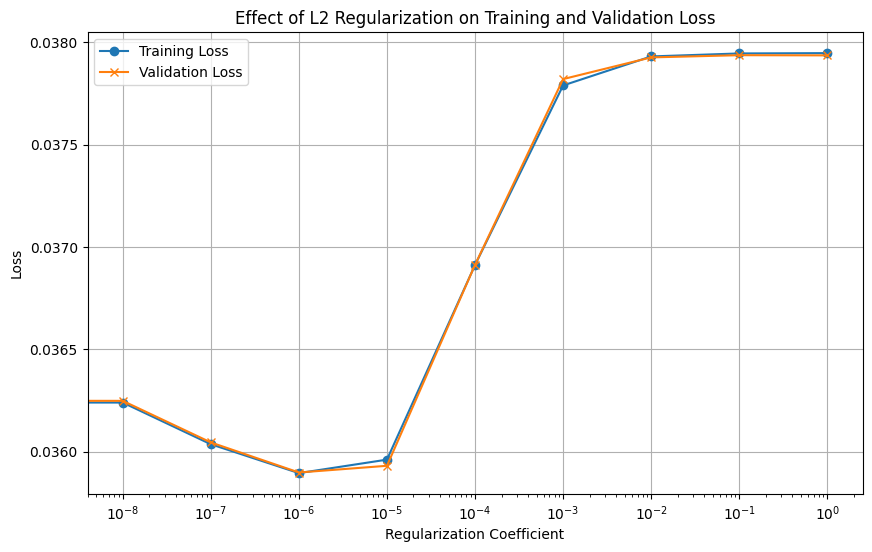

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
burrito = shmoof.SHMoofBurrito(train_df, val_df, max_length=500, kmer_length=5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=3)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/3]	 Loss: 0.03602795	 Val Loss: 0.03589880
Epoch [2/3]	 Loss: 0.03589550	 Val Loss: 0.03589847
Epoch [3/3]	 Loss: 0.03589543	 Val Loss: 0.03589846


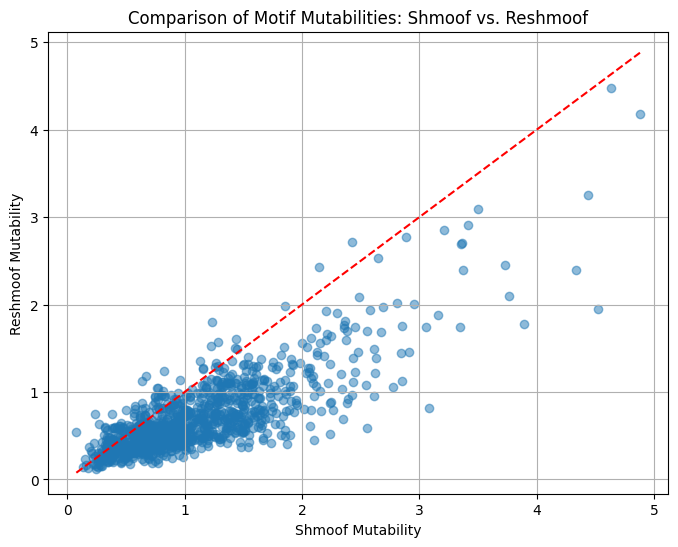

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

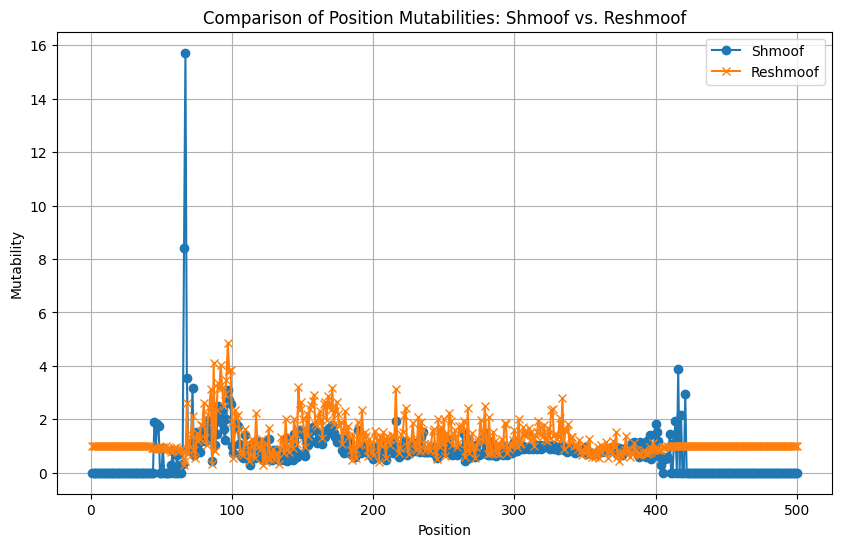

In [7]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof', marker='o')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof', marker='x')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()
